In [1]:
# usings

using Pkg; Pkg.activate(".")
using Dates
using Printf
using PyPlot

  Activating project at `~/Projects/ASTRAL/mast`


In [2]:
# general PSL DAS readers

# utility functions
m2n(x) = ismissing(x) ? NaN : x
pd = permutedims

# parameters for ASTRAL - feed defaults to functions
baseyear = 2024
mastdir = "./data/PSL/"
ncolumn = 22 # change for different file types

"yearday from Date or DateTime"
yday(dt) = Dates.value(Date(dt) - Date(year(dt)-1,12,31))
yday(ddd::AbstractString) = parse(Int, ddd)

"return all filenames with prefix and date dt"
function get_das_filenames(prefix, yd::Integer, mastdir=mastdir)
    filter(startswith(prefix), 
           readdir(joinpath(mastdir, @sprintf("%03d",yd))))
end
function get_das_filenames(prefix, dt::Date, mastdir=mastdir)
    get_das_filenames(prefix, yday(dt), mastdir)
end
"return filenames with prefix matching hour of dt"
function get_das_filenames(prefix, dt::DateTime, mastdir=mastdir)
    hh = @sprintf("%02d", Dates.value(Hour(dt)))
    filter( endswith(hh*"_raw.txt"),
            get_das_filenames(prefix, Date(dt), mastdir) )
end

"return vector of full paths of all files with prefix and date"
function get_das_pathfiles(prefix, dt, mastdir=mastdir)
    joinpath.(mastdir,
              @sprintf("%03d",yday(dt)),
              get_das_filenames(prefix, dt, mastdir))
end

"Convert a PSL date to a DateTime."
function psldatetime(d::Date, hr::Integer, psltime::AbstractString)
    mm  = Minute(     parse(Int32, psltime[1:2]))
    SS  = Second(     parse(Int32, psltime[3:4]))
    sss = Millisecond(parse(Int32, psltime[5:7]))
    DateTime(Date(d)) + Hour(hr) + mm + SS + sss
end
# function psldatetime(d::Date, hr::Integer=0, minute::Real=0)
#     DateTime(Date(d)) + Hour(hr) + Minute(minute) + Second(second)
# end
function psldatetime(yearday::Integer, hr::Integer=0; minute::Real=0, baseyear=baseyear)
    DateTime(baseyear-1,12,31) + Day(yearday) + Hour(hr) + Minute(minute)
end
# psldatetime(Date(2024,5,8), hr, "0606111")
# To get filename from the date, hour
# psldatefile(prefix, psldatetime(d, hr, psltime))

# file format default parameters
nheader = 1
# dt = DateTime(2024,5,8,11,0,0)
# pathfilename = get_das_pathfiles(prefix, dt::DateTime, mastdir=mastdir)

"read das data and put in a dictionary"
function read_das_dict(pathfilename, keys;
    nheader=nheader,
    nsample=countlines(pathfilename) - nheader,
    ncolumn=length(keys) )

    # read data from file
    datatime, X = read_das_data(pathfilename; 
        nheader=nheader,
        nsample=countlines(pathfilename) - nheader,
        ncolumn=length(keys) )
    
    return das_dict(keys, datatime, X) # returns dict
end

"read das file data"
function read_das_data(pathfilename;
    nheader=nheader,
    nsample=countlines(pathfilename) - nheader,
    ncolumn=ncolumn )

    # preallocate the data
    psltime = Vector{String}(undef, nsample) # will point to data as it is read
    X = Array{Union{Float32,Missing}, 2}(undef, nsample, ncolumn-1)
    fill!(X, missing)

    open(pathfilename) do file
        for _ in 1:nheader
            readline(file) # skip header
        end
        nl = 0
        for line in readlines(file)
            nl += 1
            splt = split(line, [' ',',','\t'])
            psltime[nl] = splt[1]
            dataline = parse.(Float32, splt[2:end])
            nx = min(ncolumn, length(dataline))
            X[nl,1:nx] .= dataline[1:nx]
        end
    end

    # find hour from the filename
    shortfilename = last(splitpath(pathfilename))
    ddd = shortfilename[end-12:end-10]
    basedt = Date(baseyear-1,12,31) + Day(yday(ddd))
    hr = parse(Int32, shortfilename[end-9:end-8])
    psldt = psldatetime.(basedt, hr, psltime)
    return psldt, X
end

# concatentate the data like this
# X = cat(X1,X2, dims=1)
# dt = cat(dt1,dt2, dims=1)
"read and concatenate data from multiple files"
function read_das_dict(pathfilenames::Vector{String}, keys;
    nheader=nheader,
    nsample=sum( countlines.(pathfilenames) ),
    ncolumn=length(keys) )
    
    dt = Vector{DateTime}(undef, nsample)
    X  = Array{Union{Float32,Missing}, 2}(undef, nsample, length(keys)-1)
    
    # append data for each station
    nl = 0
    for pfn in pathfilenames
        tdt,tX = read_das_data(pfn)
        count = length(tdt)
        dt[nl+1:nl+count  ]   .= tdt
        X[ nl+1:nl+count,:] .=  tX
        nl += count
    end
    return das_dict(keys, dt[1:nl], X[1:nl,:])
end

# Dicts are just mutable groups bound to data.
# Data in dictionaries don't need to be allocated.

"assign data to a dict of keys"
function das_dict(keys, datatime, X)
    D = Dict{eltype(keys), Any}()

    # special DateTime
    D[keys[1]] = datatime 
    # fill rest of dictionary
    for (ik, ky) in enumerate(keys[2:end])
        D[ky] = X[:, ik]
    end
    return D
end

das_dict

In [15]:
# nheader = 1
# ncolumn = 7
"read gps file GPRMC data into a dict"
function read_gps_dict(pathfilename;
    nheader=1,
    nsample=countlines(pathfilename) - nheader,
    ncolumn=7 )

    # find datetime from the filename
    shortfilename = last(splitpath(pathfilename))
    ddd = shortfilename[end-12:end-10]
    basedt = Date(baseyear-1,12,31) + Day(yday(ddd))
    hr = parse(Int32, shortfilename[end-9:end-8])
    # method: psldatetime(d::Date, hr::Integer, psltime::String)

    # preallocate the data
    psldt  = Vector{DateTime}(undef, nsample) # will point to data as it is read
    gpsdt  = Vector{DateTime}(undef, nsample) # will point to data as it is read
    lat    = Vector{Float64}(undef, nsample)
    lon    = Vector{Float64}(undef, nsample)
    speed  = Vector{Float64}(undef, nsample)
    course = Vector{Float64}(undef, nsample)

    nl=0
    open(pathfilename) do file
        for _ in 1:nheader
            readline(file) # skip header
        end
        for line in readlines(file)
            fields = split(line, [' ','\t'])
            if startswith(fields[2], "\$GPRMC")
                nl += 1
                psltime = fields[1] # string
                psldt[nl] = psldatetime(Date(basedt), hr, psltime)
                gpsdt[nl], lat[nl], lon[nl], speed[nl], course[nl] = parse_gprmc(fields[2])
            end
        end
    end

    # Return a dictionary with the parsed fields
    D = Dict{Symbol, Any}()
    # DateTime
    D[:time]     = psldt[1:nl]
    D[:gpstime]  = gpsdt[1:nl]
    # Float
    D[:lat]      = lat[1:nl]
    D[:lon]      = lon[1:nl]
    D[:sog_kts]  = speed[1:nl]
    D[:cog_deg]  = course[1:nl]

    return D
end

"""
Parse one GPRMC NMEA message.

Arguments:
- `message::String`: GPRMC NMEA message

Returns:
- A dictionary containing the parsed fields
"""
function parse_gprmc(message::AbstractString)
    # Split the message into fields
    fields = split(message, ",")
    
    # Check that the message is a GPRMC message
    # and position is valid.
    if fields[1] != "\$GPRMC"
        error("Not a GPRMC message")
    elseif fields[3] != "A"
        error("Invalid position status")
    end
    
    # Extract the fields
    time_str = fields[2]
    # status = fields[3]
    lat_str = fields[4]
    lat_dir = fields[5]
    lon_str = fields[6]
    lon_dir = fields[7]
    speed_str = fields[8]
    course_str = fields[9]
    date_str = fields[10]
    
    # Parse the time (hhmmss.sss) and date (ddmmyy)
    time = tryparse(Time, time_str[1:6], dateformat"HHMMSS")
    date = tryparse(Date, date_str, dateformat"ddmmyy")

    # Combine date and time into a DateTime object
    gpstime = try 
        DateTime(date, time) 
    catch 
        @warn "Invalid date or time format"
    end

    # Parse latitude and longitude in degrees and minutes (ddmm.mmmm)
    lat_deg = tryparse(Float64, lat_str[1:2])
    lat_min = tryparse(Float64, lat_str[3:end])
    lat = lat_deg + lat_min / 60
    if lat_dir == "S"
        lat = -lat
    end

    lon_deg = tryparse(Float64, lon_str[1:3])
    lon_min = tryparse(Float64, lon_str[4:end])
    lon = lon_deg + lon_min / 60
    if lon_dir == "W"
        lon = -lon
    end

    # Parse speed (knots) and course (degrees)
    speed = tryparse(Float64, speed_str)
    course = tryparse(Float64, course_str)

    # Return a dictionary with the parsed fields
    return gpstime, lat, lon, speed, course
end

# Example usage
message = "\$GPRMC,123519,A,4807.038,N,01131.000,E,022.4,084.4,230394,003.1,W*6A"
parsed_data = parse_gprmc(message)
# println(parsed_data)

mastdir = "./data/PSL"
dt = DateTime(2024,5,8)
pathfilename = get_das_pathfiles("gps", dt, mastdir)[1]
Gps = read_gps_dict(pathfilename)

Dict{Symbol, Any} with 6 entries:
  :gpstime => [DateTime("0024-05-08T00:00:00"), DateTime("0024-05-08T00:00:01")…
  :cog_deg => [201.37, 201.05, 199.71, 199.29, 198.64, 195.9, 195.06, 194.66, 1…
  :sog_kts => [8.14, 8.28, 8.39, 8.44, 8.26, 8.53, 8.23, 8.6, 8.44, 8.32  …  0.…
  :lat     => [3.34709, 3.34708, 3.34707, 3.34706, 3.34706, 3.34705, 3.34704, 3…
  :lon     => [84.6788, 84.6788, 84.6787, 84.6787, 84.6787, 84.6787, 84.6787, 8…
  :time    => [DateTime("2024-05-08T00:00:00.054"), DateTime("2024-05-08T00:00:…

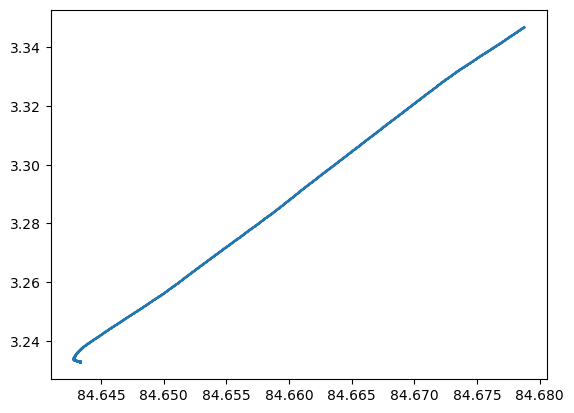

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x338c1d990>

In [23]:
plot(Gps[:lon],Gps[:lat], marker=".", markersize=0.1, linewidth=0.25)

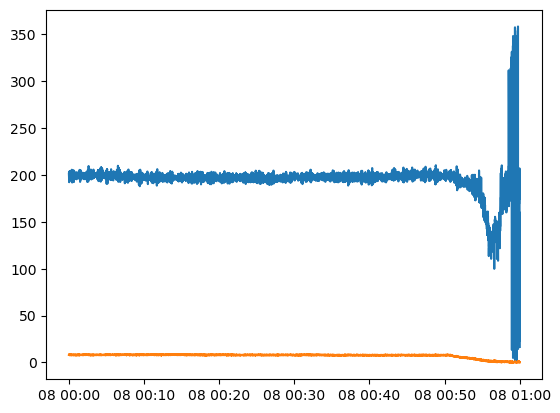

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x338bbad70>

In [22]:
plot(Gps[:time], Gps[:cog_deg])
plot(Gps[:time], Gps[:sog_kts])